# PDE-Net 2.0 for 2D Burgers equation
## —— Multistep training

In [1]:
import argparse
import os
import mindspore as ms
import numpy as np
from mindspore import nn
from mindspore.amp import all_finite
from src.dataset import DataGenerator
from src.pdenet import PDENetWithLoss
from src.utils import init_env, get_config, init_model, load_param_dict, mkdir, generate_train_data
from src.utils import test, evaluate
from mindspore.train.serialization import load_param_into_net

## Training environment settings

In [2]:
ms.set_seed(1999)
np.random.seed(1999)
my_config = get_config('config.yaml')
my_config['device_target'] = 'CPU'
mkdir(config=my_config)
ms.set_context(mode=ms.PYNATIVE_MODE, device_target=my_config['device_target'], device_id=0)

## Define single step training

In [3]:
def single_train(step_num: int, config: dict, data_generator: DataGenerator):
    # generate data: (data_num, step_num + 1, 2, sample_mesh_size_y, sample_mesh_size_x)
    train_dataset = generate_train_data(config=config, data_generator=data_generator)
    pde_net = init_model(config=config)
    if step_num == 1:
        # warm up
        regularization = False
        frozen = True
        pde_net.set_frozen(frozen=frozen)
        epochs = config['warmup_epochs']
        lr = config['warmup_lr']
    else:
        if step_num == 2:
            load_epoch = config['warmup_epochs']
        else:
            load_epoch = config['epochs']

        param_dict = load_param_dict(save_directory=config['save_directory'], step=step_num - 1, epoch=load_epoch)
        param_not_load = load_param_into_net(net=pde_net, parameter_dict=param_dict)
        print('=============== Net saved at last step is loaded. ===============')
        print('!!!!!!!!! param not loaded: ', param_not_load)

        regularization = True
        frozen = False
        pde_net.set_frozen(frozen=frozen)
        epochs = config['epochs']
        lr = config['lr'] * np.power(config['lr_reduce_gamma'], (step_num - 1) // config['lr_reduce_interval'])

    # lr scheduler
    my_optimizer = nn.Adam(params=pde_net.trainable_params(), learning_rate=lr)
    net_with_loss = PDENetWithLoss(pde_net=pde_net,
                                   moment_loss_threshold=config['moment_loss_threshold'],
                                   symnet_loss_threshold=config['symnet_loss_threshold'],
                                   moment_loss_scale=config['moment_loss_scale'],
                                   symnet_loss_scale=config['symnet_loss_scale'],
                                   step_num=step_num, regularization=regularization)

    def forward_fn(trajectory):
        loss = net_with_loss.get_loss(batch_trajectory=trajectory)
        return loss
    value_and_grad = ms.ops.value_and_grad(forward_fn, None, weights=my_optimizer.parameters)

    def train_process(trajectory):
        # TNCHW
        trajectory = ms.numpy.swapaxes(trajectory, 0, 1)
        loss, grads = value_and_grad(trajectory)
        if config['device_target'].upper() == 'ASCEND':
            status = ms.numpy.zeros((8, ))
        else:
            status = None
        if all_finite(grads, status=status):
            my_optimizer(grads)
        return loss

    for epoch_idx in range(1, epochs + 1):
        pde_net.set_train(mode=True)
        avg_loss = 0
        for batch_trajectory in train_dataset.fetch():
            train_loss = train_process(batch_trajectory)
            avg_loss += train_loss.asnumpy()
        print('step_num: {} -- epoch: {} -- lr: {} -- loss: {}'.format(step_num, epoch_idx,
                                                                       my_optimizer.learning_rate.value(),
                                                                       avg_loss))
        # generate new data
        if epoch_idx % config['generate_data_interval'] == 0:
            train_dataset = generate_train_data(config=config, data_generator=data_generator)
        # evaluate
        if epoch_idx % config['evaluate_interval'] == 0:
            evaluate_error = evaluate(model=pde_net, data_generator=data_generator, config=config, step_num=step_num)
            print('=============== Max evaluate error: {} ==============='.format(evaluate_error))
            print('=============== Current Expression ===============')
            pde_net.show_expression(coe_threshold=config['coe_threshold'])

        if epoch_idx == epochs:
            print('=============== Current Expression ===============')
            pde_net.show_expression(coe_threshold=config['coe_threshold'])
            pde_net.show_kernels()
            save_path = os.path.join(config['save_directory'],
                                     'pde_net_step{}_epoch{}.ckpt'.format(step_num, epoch_idx))
            ms.save_checkpoint(pde_net, save_path)
    return

## Multistep training

In [4]:
def train(config):
    data_generator = DataGenerator(config=config)
    for step_num in range(2, config['blocks_num'] + 1):
        single_train(config=config, step_num=step_num, data_generator=data_generator)
    return

In [5]:
train(config=my_config)

generating data ...
step 20 generated.
generated.
=============== Net saved at last step is loaded. ===============
!!!!!!!!! param not loaded:  []
step_num: 2 -- epoch: 1 -- lr: 0.001 -- loss: 1.2763880491256714
step_num: 2 -- epoch: 2 -- lr: 0.001 -- loss: 1.2428737580776215
step_num: 2 -- epoch: 3 -- lr: 0.001 -- loss: 1.2293831408023834
step_num: 2 -- epoch: 4 -- lr: 0.001 -- loss: 1.227841079235077
step_num: 2 -- epoch: 5 -- lr: 0.001 -- loss: 1.2169044613838196
step_num: 2 -- epoch: 6 -- lr: 0.001 -- loss: 1.205796331167221
step_num: 2 -- epoch: 7 -- lr: 0.001 -- loss: 1.1973368227481842
step_num: 2 -- epoch: 8 -- lr: 0.001 -- loss: 1.187659502029419
step_num: 2 -- epoch: 9 -- lr: 0.001 -- loss: 1.1864047348499298
step_num: 2 -- epoch: 10 -- lr: 0.001 -- loss: 1.1783793270587921
step_num: 2 -- epoch: 11 -- lr: 0.001 -- loss: 1.184253305196762
step_num: 2 -- epoch: 12 -- lr: 0.001 -- loss: 1.172987848520279
step_num: 2 -- epoch: 13 -- lr: 0.001 -- loss: 1.1686180531978607
step_num

## Test and visualization

=============== Net saved at last step is loaded. ===============
predicting data_num 20 step 1 ...
predicting data_num 20 step 2 ...
predicting data_num 20 step 3 ...
predicting data_num 20 step 4 ...
predicting data_num 20 step 5 ...
predicting data_num 20 step 6 ...
predicting data_num 20 step 7 ...
predicting data_num 20 step 8 ...
predicting data_num 20 step 9 ...
predicting data_num 20 step 10 ...
predicting data_num 20 step 11 ...
predicting data_num 20 step 12 ...
predicting data_num 20 step 13 ...
predicting data_num 20 step 14 ...
predicting data_num 20 step 15 ...
predicting data_num 20 step 16 ...
predicting data_num 20 step 17 ...
predicting data_num 20 step 18 ...
predicting data_num 20 step 19 ...
predicting data_num 20 step 20 ...
predicting data_num 20 step 21 ...
predicting data_num 20 step 22 ...
predicting data_num 20 step 23 ...
predicting data_num 20 step 24 ...
predicting data_num 20 step 25 ...
predicting data_num 20 step 26 ...
predicting data_num 20 step 27 ..

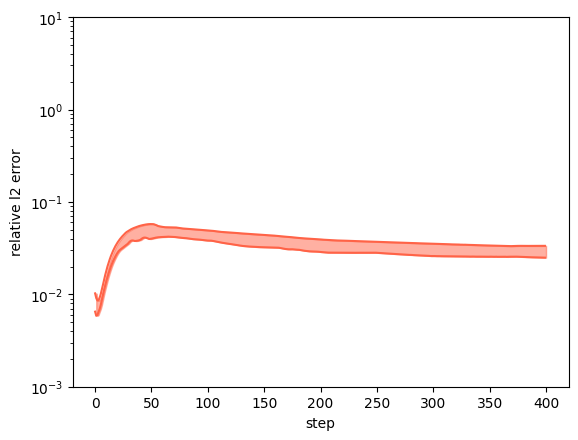

<Figure size 600x500 with 0 Axes>

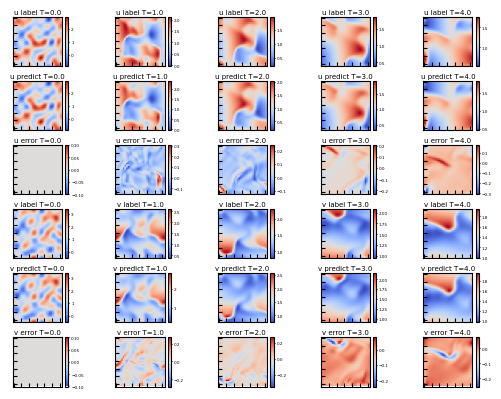

In [6]:
test(config=my_config, show_results=True)